Equilibrium density in a linear chain
======================================

In this example we calculate the carrier density for a system at equilibrium. 

In [1]:
import numpy
import pynegf
import scipy
import matplotlib.pyplot as plt
from scipy import sparse

We define the hamiltonian for a linear chain similar to other example. We will use the minimum contact dimension, i.e. 2 sites. 

In [2]:
def orthogonal_linear_chain(nsites=100, contact_size=2, coupling=1.0):
    mat = numpy.zeros(shape=(nsites, nsites), dtype='complex128')

    for i in range(nsites - contact_size):
        mat[i - 1, i] = coupling
    for i in range(nsites - contact_size, nsites):
        mat[i - 1, i] = coupling
    mat[0, nsites - contact_size] = coupling

    mat_csr = sparse.csr_matrix(mat)
    mat_csr = mat_csr + mat_csr.getH()
    mat_csr.sort_indices()

    return mat_csr

mat_csr = orthogonal_linear_chain()

We define the system structure in the same way as in the previous examples.  

In [3]:
negf = pynegf.PyNegf()
negf.set_hamiltonian(mat_csr)
negf.set_identity_overlap(100)
negf.init_structure(
        ncont=2,
        contend=numpy.array([97, 99]),
        surfend=numpy.array([95, 97]))

INFO:root:Running libnegf on 1 processes


Next, we set some parameters relevant for the density calculation. `libnegf` supports two different carrier representation: a full-band one where all carriers are electrons, and an electron-hole description suitable to split electron and hole densities in separate contributions. 

In this example we will use a full-band representation. In this case the density is evaluated using a complex contour integration (see [dftb manual](https://www.dftbplus.org/fileadmin/DFTBPLUS/public/dftbplus/latest/manual.pdf)). In particular, we need to specify the minimum energy used for the integration `ec`. This value should be lower than the lowest eigenvalue of the system. Other relevant parameters are `np_n[2]`, `n_poles`, `kbt_dm[ncontacts]` for equilibrium and `n_kt`, `np_real`, `min_or_max` for non-equilibrium. 

In [4]:
negf.params.ec = -2.5
negf.params.kbt_dm = (.001, .001)
negf.params.g_spin = 2.0
# Not correctly initialized, setting explicitely.
negf.params.np_real = tuple([0] * 11)
negf.params.verbose = 100
negf.set_params()

negf.solve_density()

After solving the system we can retrieve the density matrix. Note that libnegf only computes density matrix elements which correspond to a finite overlap. In this we have an orthogonal representation, therefore we will obtain a diagnoal matrix. 

The system is ballistic and has one band going from -2 to +2. Therefore each site should be half-occupied. The spin-degeneracy is 2 and we expect to have a particle per site.

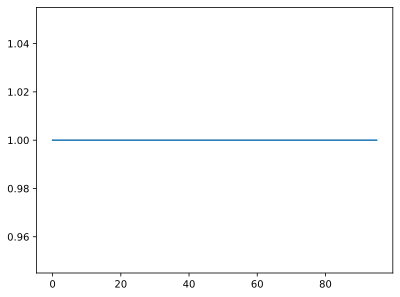

In [5]:
density_matrix = negf.density_matrix()
diagonal = numpy.real(density_matrix.diagonal())
plt.plot(diagonal[:96])
plt.show()

We can get a less boring occupation if the system has some disorder. In this case we will expect the occupation to vary along the chain. We can introduce for example some Anderson disorder in the original hamiltonian, and tun the calculation again. Note that we can not add the noise in the contacts, or the periodic repetitions will not be recognized as such.

In [6]:
noise = (numpy.random.rand(100) - 0.5)
noise[76:] = 0.0 # Add noise only in the central region, leaving some additional sites near the contacts.
noise[:26] = 0.0
mat_csr.setdiag(mat_csr.diagonal() + noise)

# We need to create a new instance when we reset hamiltonian and structure. 
negf = pynegf.PyNegf()
negf.set_hamiltonian(mat_csr)
negf.set_identity_overlap(100)
negf.init_structure(
        ncont=2,
        contend=numpy.array([97, 99]),
        surfend=numpy.array([95, 97]))
negf.params.ec = -3.0
negf.params.kbt_dm = (.001, .001)
negf.params.g_spin = 2.0
# Not correctly initialized, setting explicitely.
negf.params.np_real = tuple([0] * 11)
negf.params.verbose = 100

negf.solve_density()

INFO:root:Running libnegf on 1 processes


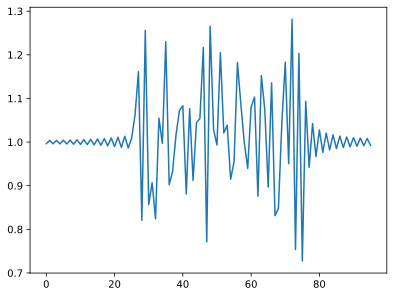

In [7]:
density_matrix = negf.density_matrix()
diagonal = numpy.real(density_matrix.diagonal())
plt.plot(diagonal[:96])
plt.show()